In [1]:
using Plots; #gr() #pyplot()
using LaTeXStrings

In [2]:
using DifferentialEquations

In [3]:
function NonLinearCells!(du, us, p, t)
    c₁, c₂, m = us
    cₜ = c₁ + c₂

    # More nightmare syntax, making du elementwise equal to this bitch
    du .= [
        (p.ω[1,1] - p.f[1,1] * cₜ - q₁ * m) * c₁ + p.w₂ * c₂, #dc₁
        (p.ω[2,2] - p.f[2,2] * cₜ) * c₂ + p.w₁ * c₁,          #dc₂
        p.m₀ - p.qₘ * c₂ * m                          #dm 
    ]
end;

In [4]:
function NonLinearCells_jac!(J, us, p, t)
    c₁, c₂, m = us
    cₜ = c₁ + c₂

    J[1,1] = p.ω[1,1] - p.f[1,1] * (2 * c₁ + c₂) - p.q₁*m
    J[1,2] = p.f[2,2] * c₂ + p.w₁
    J[1,3] = 0
    J[2,1] = p.f[1,1] * c₁ + p.w₂
    J[2,2] = p.ω[2,2] - p.f[2,2] * (c₁ + 2 * c₂)
    J[2,3] = -p.qₘ * m
    J[3,1] = -p.q₁ * c₁
    J[3,2] = 0
    J[3,3] = -p.qₘ * c₂
end;

In [5]:
n₁ = 100 ; n₂ = 99 ;

In [6]:
k₁ = 2 ; k₂ = 2 ;

In [7]:
w₁ = 0.01 ; w₂ = 0.02 ;

In [8]:
q₁ = 0.999
qₘ = 0.8

m₀ = 0;

In [9]:
f = [k₁ / n₁ k₁ / n₂ ; k₂ / n₁ k₂ / n₂];
ω = [k₁ - w₁ k₁ - w₂ ; k₂ - w₁ k₂ - w₂];

In [10]:
t₀ = 0
tₑ = 100
t_span = (t₀, tₑ);

In [11]:
p = (;
    w₁, w₂, 
    m₀, q₁, qₘ,
    f, ω
);

In [12]:
u₀ = [n₁ - 1; 1; m₀];

In [13]:
func = ODEFunction(NonLinearCells!; jac = NonLinearCells_jac!);

In [14]:
prob = ODEProblem(func, u₀, t_span, p; tstops=t_span);
# alg = Tsit5()
alg = SIR54()
sol = solve(prob, alg);

In [15]:

# dt = 0.01
# sol = solve(prob, Eular(); dt=dt, reltol=1e-7, abstol=1e-7);

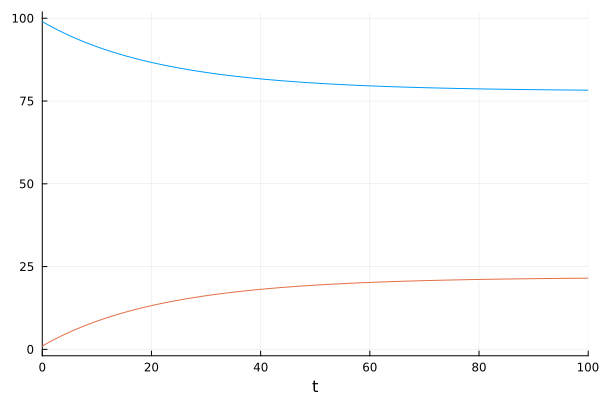

In [16]:
gr()
ode_plot = plot(sol; 
    idxs=[1, 2], # Specifies which solutions I care to be plotted
    # idxs=(1, 2), # Sets up our phase space, comparing solution 1 to solution 2
    leg = false,
    plotdensity=10_000 # Ensures the right dpi for plot appearence
    )

In [17]:
c₁ = c₁_of_t = sol[1,:] ; c₂ = c₂_of_t = sol[2,:]
cₜ = c₁ .+ c₂

c₁_percent = c₁_of_t ./ n₁ ; c₂_percent = c₂_of_t ./ n₂
c_percent = c₁_percent .+ c₂_percent;

In [18]:
println(minimum(c_percent), "   " , maximum(c_percent))

1.000000648098913   1.0001010101010102


In [19]:
# @. n₂ * (1 - c₁ * n₁^-1)
# c₂

In [20]:
@. cₜ * (1/n₁ + 1/n₂)

81037-element Vector{Float64}:
 2.0101010101010104
 2.0101009181932925
 2.01010087846175
 2.010100838188793
 2.010100800088052
 2.010100763722053
 2.010100728939338
 2.0101006955873273
 2.0101006635324516
 2.0101006326565725
 ⋮
 2.005736993884613
 2.005736836481476
 2.0057366790873195
 2.0057365217021985
 2.0057363643261734
 2.005736206959305
 2.0057360496016723
 2.0057358922533224
 2.0057357400198312

In [22]:
c_q = 2*n₁*n₂ /(n₁+n₂)

99.49748743718592

In [23]:
c_q / n₁

0.9949748743718593

In [24]:
#dc₁ = c₁ -> (ω[1,1]-f[1,1]*c_q) * c₁ + w₂*(c_q - c₁)
#dc₁(c_f);

In [25]:
total_percents = cₜ ./ c_percent;

In [26]:
c₁_f = -(w₂*c_q) / ((ω[1,1] - f[1,1] * c_q) - w₂)

99.74811083123443

In [27]:
c₂_f = (n₁ - c₁_f)

0.25188916876557244

In [ ]:
c₂_fixed = -(w₁ * n₁)/ (ω[2,2] - f[2,2] * n₁ - w₁)
c₁_fixed = @. (-w₂*c₂)/(ω[1,1]-f[1,1] * cₜ);

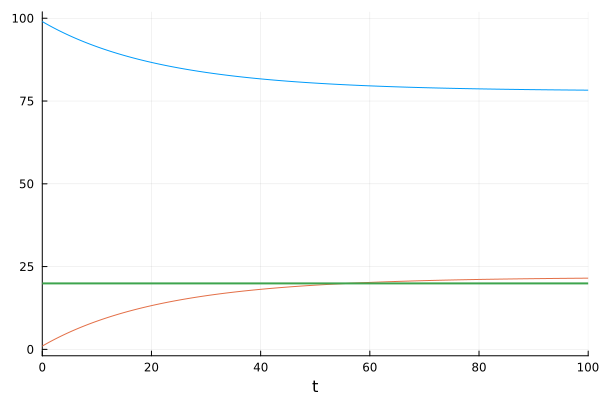

In [53]:
gr()
plot(ode_plot)
hline!([c₂_fixed]; linewidth=2)

## Quiver

In [29]:
function meshgrid_old(n)
    xs = ones(n) .* (1:n)'
    ys = xs'
    xys = permutedims(cat(xs, ys; dims = 3), [3, 1, 2])
    return reshape(xys, 2, n^2)
end;

In [30]:
meshgrid(x, y) = (repeat(x, outer=length(y)), repeat(y, inner=length(x)));

In [31]:
dc₁(c₁, c₂, m) = (p.ω[1,1] - p.f[1,1] * (c₁ + c₂) - q₁ * m) * c₁ + p.w₂ * c₂;
dc₂(c₁, c₂, m) = (p.ω[2,2] - p.f[2,2] * (c₁ + c₂)) * c₂ + p.w₁ * c₁;
dm(c₁, c₂, m)  = p.m₀ - p.qₘ * c₂ * m;

In [32]:
uc₁ = [ -(w₂ * c_q)/(ω[1,1] - f[1,1]*c_q - w₂); 0; 0]
uc₂ = [ -(w₂ * c_q)/(ω[1,1] - f[1,1]*c_q - w₂); 0; 0]

3-element Vector{Float64}:
 99.74811083123443
  0.0
  0.0

In [33]:
quiver_time_span = (0,150)

(0, 150)

In [34]:
quiver_prob = ODEProblem(func, uc₁, quiver_time_span, p; tstops=quiver_time_span);
quiver_sol  = solve(quiver_prob, alg)

retcode: Success
Interpolation: 3rd order Hermite
t: 262871-element Vector{Float64}:
   0.0
   2.145312668640609e-7
   3.0733673632520963e-7
   4.014305936350598e-7
   4.904733963357636e-7
   5.754835814545535e-7
   6.568121713979189e-7
   7.348134160023045e-7
   8.097972560531859e-7
   8.820380272119455e-7
   ⋮
 147.14442183725384
 147.4982022562335
 147.85645057498022
 148.21927405816533
 148.58678372439277
 148.9590945214387
 149.3363255628007
 149.71860029694406
 150.0
u: 262871-element Vector{Vector{Float64}}:
 [99.74811083123443, 0.0, 0.0]
 [99.7481107250475, 2.1399088491932584e-7, 0.0]
 [99.74811067911139, 3.0656258648685063e-7, 0.0]
 [99.74811063253756, 4.004194302286966e-7, 0.0]
 [99.74811058846385, 4.89237942166487e-7, 0.0]
 [99.74811054638616, 5.740339940254206e-7, 0.0]
 [99.74811050613076, 6.551577240564627e-7, 0.0]
 [99.7481104675223, 7.329624898045938e-7, 0.0]
 [99.74811043040735, 8.077574513691151e-7, 0.0]
 [99.74811039465015, 8.798162534070536e-7, 0.0]
 ⋮
 [78.016227929

In [35]:
#c₁_null = @. dc₁(-(w₂*c_q) / )
#c₂_null = dc₂()

In [37]:
z_norm = @. sqrt.(c₁_vecs^2 + c₂_vecs^2);
quiver_plot = contour(c₁_vecs, c₂_vecs, z_norm)

UndefVarError: UndefVarError: `c₁_vecs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [38]:
# grid = abs.(meshgrid(40) ./ 2 .- [1; 99])
x_range = 0:2:100
y_range = 0:2:100

x, y = meshgrid(x_range, y_range);

In [39]:
scaling_const = 1/100;

c₁_vecs = @. dc₁(x, y, 0) * scaling_const;
c₂_vecs = @. dc₂(x, y, 0) * scaling_const;

/home/anakin/.julia/artifacts/872754c2f795d19a3e2e205b2bbaea659f28d11e/lib/libudev.so: version `LIBUDEV_247' not found (required by /lib/x86_64-linux-gnu/libgudev-1.0.so.0)
Failed to load module: /usr/lib/x86_64-linux-gnu/gtk-4.0/4.0.0/media/libmedia-gstreamer.so


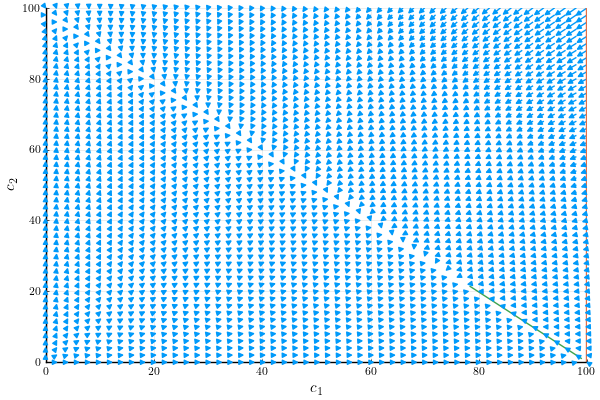

In [41]:
pyplot()
quiver_plot = quiver(x, y, quiver=(c₁_vecs, c₂_vecs))
xlims!(0,100)
ylims!(0,100)


xlabel!(L"c_1")
ylabel!(L"c_2")

vline!([uc₁[1:2]...]; leg=false)
plot!(c₁, c₂)
# plot!(quiver_sol; 
#     color=:black,
#     leg=false, idxs=(2,1), plotdensity=10_000
# )

### With GMT

In [42]:
# using GMT

In [43]:
# xx, yy = GMT.meshgrid(x_range, y_range)

In [44]:
U = dc₁.(xx, yy, 0)
V = dc₂.(xx, yy, 0)

UndefVarError: UndefVarError: `xx` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [45]:
p = quiver(x, y, quiver=(U,V))
plot(p; show=true)

UndefVarError: UndefVarError: `U` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [46]:
startx = linspace(0,100,100)
starty = zeros(length(startx))

p = streamlines(U, V, startx, starty)
plot(p, show=true)

UndefVarError: UndefVarError: `linspace` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [47]:
# U = mat2grid(dc₁.(xx, yy, 0), )

In [48]:
for (i, sign) ∈ enumerate([-, +])
    println(sign(2, 1))
end;

1
3


In [49]:
a = f[1,1]*((n₁ - n₂)/n₁);
b = ω[1,1] * (n₂/n₁) + ω[1,2];
c = w₁*n₂;

In [50]:
function roots(a,b,c)
    output = Vector{Union{Float64,Missing}}(undef, 2)

    for (i, sign) ∈ enumerate([-, +])
        disc = b^2 - 4 * a * c
        back = sqrt(disc) / (2 * a)

        front = -b / (2 * a)

        output[i] = sign(front, back)
    end

    return output
end;

In [51]:
λ = roots(a, b, c)

2-element Vector{Union{Missing, Float64}}:
 -19750.249370253143
     -0.25062974685533845